In [18]:
import scipy
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import os
from scipy.io import loadmat, savemat
from matplotlib.colors import LogNorm

In [19]:
def getFilePaths(outfileName):
    filePathsByMonth = {"01": [], "02": [],"03": [],"04":[],"05":[],"06":[],"07":[],"08":[],"09":[],"10":[],"11":[],"12":[]}

    # GET ALL FILE PATHS in GLD_cleaned FOLDER
    GLD_cleaned_path = r'/Volumes/lairdata/lightningdata/GLD_cleaned/'
    allFolders = os.listdir(GLD_cleaned_path) # gets list of all folders in GLD_cleaned

    for folderDate in allFolders: # getting file paths by month
        date = folderDate.split("-")
        month = date[1]
        
        fileInFolder = os.listdir(GLD_cleaned_path + str(folderDate)) 
        pathToFile = GLD_cleaned_path + str(folderDate) + "/" + fileInFolder[0]
        
        filePathsByMonth[month].append(pathToFile)

    # GET ALL FILE PATHS in FROM_ALEXANDRIA FOLDER
    FROM_ALEXANDRIA_path = r'/Volumes/lairdata/lightningdata/From Alexandria/GLD_cleaned/Matlab/'
    Folders = os.listdir(FROM_ALEXANDRIA_path)

    for folder in Folders:
        if not folder.startswith('.'): # getting list of all file names
            AllFiles = os.listdir(FROM_ALEXANDRIA_path + '/' + folder)
            
            for filename in AllFiles: # extracting month from each and adding to filePathsByMonth dictionary
                date = ''.join(filter(str.isdigit, filename))
                month = date[4:6]
                pathToFile = FROM_ALEXANDRIA_path + folder + '/' + filename
                #print(pathToFile)
                filePathsByMonth[month].append(pathToFile)

    # SAVING ALL FILE NAMES BY MONTH
    #np.save(outfileName, filePathsByMonth) 

def GetFilePathsSeason(pathname, outfileName):
    # GETTING FILE PATHS BY SEASON FOR GLD_CLEANED FOLDER
    filePathsBySeason = {"Winter": [], "Spring": [], "Summer": [], "Fall": []}
    dictionary = np.load(pathname, allow_pickle = True)
    pathsByMonth = dictionary.item()
    for month, filepaths in pathsByMonth.items():
        if month == "12" or month == "01" or month == "02":
            filePathsBySeason["Winter"] += filepaths
        elif month == "03" or month == "04" or month == "05":
            filePathsBySeason["Spring"] += filepaths
        elif month == "06" or month == "07" or month == "08":
            filePathsBySeason["Summer"] += filepaths 
        elif month == "09" or month == "10" or month == "11":
            filePathsBySeason["Fall"] += filepaths

    # SAVING ALL FILE NAMES BY SEASON
    #np.save(outfileName, filePathsBySeason) 

In [20]:
dictionary = np.load('2015/Data/filePathsSeason2015.npy', allow_pickle = True)
pathsBySeason = dictionary.item()

In [21]:
def getFlashData():
    for season, filePaths in pathsBySeason.items():
        flashData = loadmat(filePaths[0]).get("flashes")
        for filepath in filePaths[1:]:
            data = loadmat(filepath).get("flashes")
            flashData = np.concatenate((data, flashData))

        # computing histogram data
        m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c') # creating basemap object
        lons = flashData[:,3]
        lats = flashData[:,2] 
        values = flashData[:,4] 
        x, y = m(lons, lats) # basemap instance calculates the position of point in map coordinates, x binned along 1st dimension and y binned along 2nd dimension

        H, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(x, y, values, statistic="mean", bins=100, range=None, expand_binnumbers=False)
        #H = np.ma.masked_where(H==0, H) # masking where there was no data
        XX, YY = np.meshgrid(xedges, yedges)
        
        #np.savez(season + 'AverageData', XX=XX, YY=YY,H=H)

In [22]:
def plot(season, year, file, count):
    # computing histogram data for winter
    H = file["H"]
    XX = file["XX"]
    YY = file["YY"]
    #H = np.ma.masked_where(H==0, H) # masking where there was no data
    
    # plotting data    
    plt.subplot(2,2,count)

    m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,resolution='c')
    CS = m.pcolormesh(XX,YY,H.T, alpha = 0.85, shading='auto', cmap=plt.cm.viridis, norm = LogNorm())
    m.drawcoastlines()# draw coastlines, lat/lon lines.
    m.drawparallels(np.arange(-90.,90.,30.), labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.), labels=[1,1,0,1], rotation=45)
    m.colorbar(CS,location = "bottom",label="Average [kA]",size="5%", pad='15%') # draw colorbar

    if season == "Winter":
        plt.title('Dec/Jan/Feb Peak Current[kA] Averages ({})'.format(year), fontsize=20)
        plt.xlabel('Longitude',labelpad=30, fontsize=15)
        plt.ylabel('Latitude',labelpad=40, fontsize=15)
    elif season == "Spring":
        plt.title('March/April/May Peak Current[kA] Averages({})'.format(year), fontsize=20)
        plt.xlabel('Longitude', labelpad=30,fontsize=15)
        plt.ylabel('Latitude', labelpad=40,fontsize=15)
    elif season == "Summer":
        plt.title('June/July/August Peak Current[kA] Averages({})'.format(year), fontsize=20)
        plt.xlabel('Longitude', labelpad=30,fontsize=15)
        plt.ylabel('Latitude', labelpad=40,fontsize=15)
    elif season == "Fall":
        plt.title('Sept/Oct/Nov Peak Current[kA] Averages({})'.format(year), fontsize=20)
        plt.xlabel('Longitude', labelpad=30, fontsize=15)
        plt.ylabel('Latitude', labelpad=40, fontsize=15)

    plt.gcf().set_size_inches(20,12)

In [25]:
def plotAll():
    count = 0
    for season in pathsBySeason.keys():
        file = np.load("2015/Data/averages/"+season+".npz") # passing in scipy stats data to plotting function
        count += 1
        plot(season, year = 2015, file = file, count=count)
    
    plt.tight_layout()
    plt.savefig("2015/2015PeakCurrentOccurence", facecolor='w')


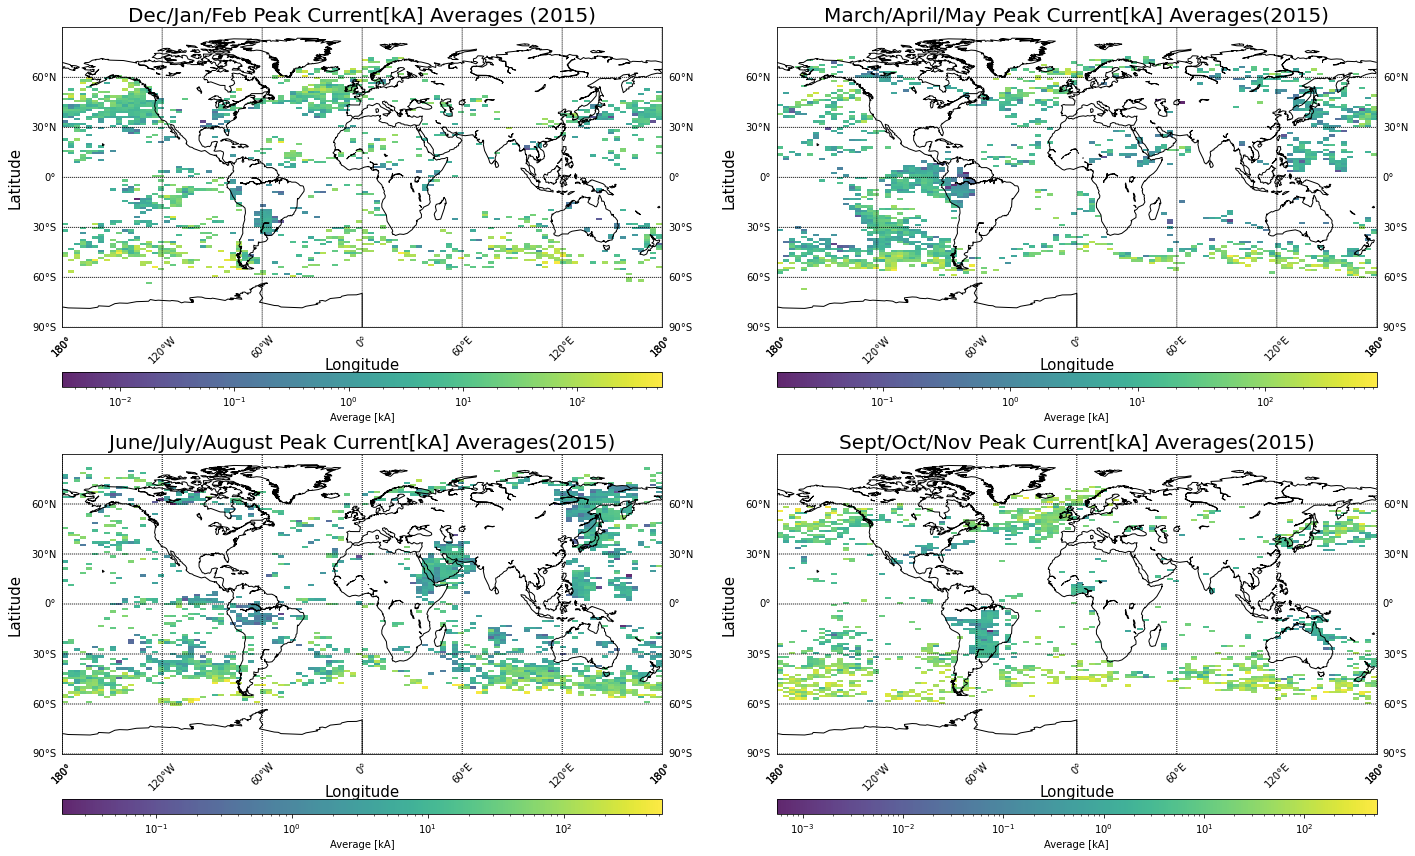

In [26]:
plotAll()